# **P1: White Noise**

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import soundfile as sf
from google.colab import files
from IPython.display import Audio

In [ ]:
def dft_matrix(N):

    dft_matrix = []
    for n in range(N):
        row = []
        for f in range(N):
            element = np.exp(-1j * (2 * np.pi * f * n / N))
            row.append(element)
        dft_matrix.append(row)

# Convert the nested list into a NumPy array
    F = np.array(dft_matrix)
    return F

In [ ]:
audio_file_path = "/content/drive/MyDrive/Colab drive/x.wav"

signal, sampling_rate = librosa.load(audio_file_path, sr=None)

print("Shape of audio signal:", signal.shape)
print("Sampling rate:", sampling_rate)

Shape of audio signal: (96245,)
Sampling rate: 16000


In [ ]:
N=1024
F = dft_matrix(N)
print('The shape of the resulting DFT matrix is: ' + str(F.shape))

The shape of the resulting DFT matrix is: (1024, 1024)


In [ ]:
hop_length = N // 2

num_frames = (len(signal) - N) // hop_length + 1
X = np.zeros((N, num_frames))

for i in range(num_frames):

    start_index = i * hop_length
    end_index = start_index + N
    frame = signal[start_index:end_index]

    hann_window = np.hanning(N)
    windowed_frame = frame * hann_window
    X[:, i] = windowed_frame


print("Shape of data matrix X:", X.shape)

Shape of data matrix X: (1024, 186)


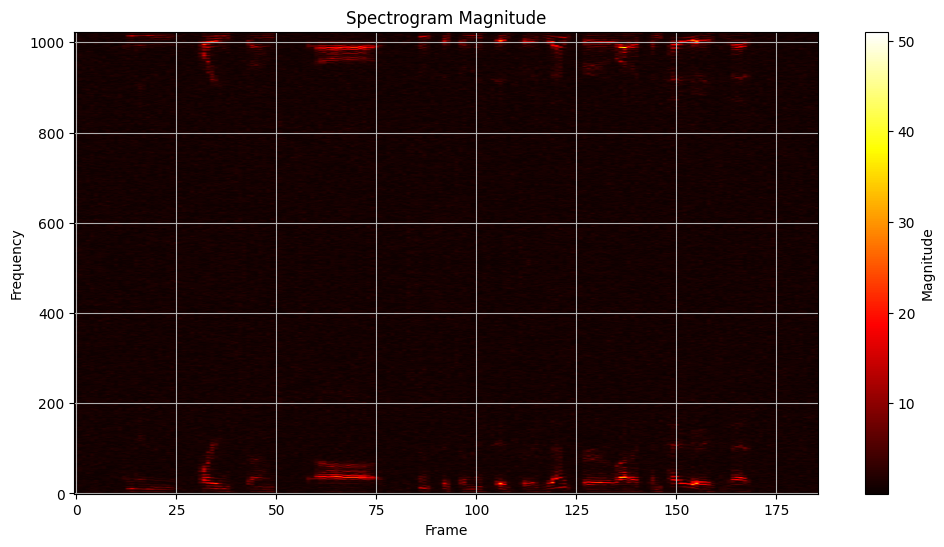

In [ ]:
# Apply the DFT matrix to the data matrix X (Y=F.X)
Y = np.dot(F, X)

# Take the magnitudes of the complex values in Y
magnitude_spectrogram = np.abs(Y)
plt.figure(figsize= (12,6))

plt.imshow(magnitude_spectrogram, cmap='hot', aspect='auto', origin='lower')
plt.xlabel('Frame')
plt.ylabel('Frequency')
plt.title('Spectrogram Magnitude')
plt.colorbar(label='Magnitude')
plt.grid(True)
plt.show()


In [ ]:
num_columns = magnitude_spectrogram.shape[1]

print("Total number of columns in the spectrogram:", num_columns)

Total number of columns in the spectrogram: 186


In [ ]:
num_columns = 11  # consider the last 11 columns (186-11 = 175 )

last_columns = magnitude_spectrogram[:, -num_columns:]
M = np.mean(last_columns)

print("Mean of the last columns of the spectrogram (M):", M)


Mean of the last columns of the spectrogram (M): 0.8603265107545348


In [ ]:
residual_magnitudes = np.maximum(0, np.abs(Y) - M)

original_phase = Y / np.maximum(np.abs(Y), 1e-12)

cleaned_spectra = original_phase * residual_magnitudes

In [ ]:
def idft_matrix(m_size):

    dft_matrix = np.array([[np.exp(1j * (2 * np.pi * f * n /m_size)) for f in range(0,m_size)] for n in range(0,m_size)])
    idft_matrix = dft_matrix/m_size

    return idft_matrix

idft_mat = idft_matrix(1600)

print('The shape of the idft matrix is: ' + str(idft_mat.shape))

The shape of the idft matrix is: (1600, 1600)


In [ ]:
def idft(N):

    dft_matrix = np.zeros((N, N), dtype=np.complex128)
    for n in range(N):
        for k in range(N):

            angle = 2 * np.pi * k * n / N
            dft_matrix[n, k] = np.exp(1j * angle)

    Fi = dft_matrix / N
    return Fi

N = 1024
Fi = idft(N)
print("The shape of the inverse dft matrix is :",Fi.shape)

The shape of the inverse dft matrix is : (1024, 1024)


In [ ]:
i_transform = np.dot(Fi, F)
print('We can see that F*F is an identity matrix: \n' + str(np.abs(np.round(i_transform.real))))

We can see that F*F is an identity matrix: 
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
X_hat = np.dot(Fi, cleaned_spectra)

In [ ]:
def reverse_overlap_and_add(X, window_size):

    reconstructed_signal = X[:(X.shape[0] - int(window_size / 2)), 0]
    for col in range(1, X.shape[1]):

        overlap_part = X[(X.shape[0] - int(window_size / 2)):, col - 1]
        add_part = X[0:int(window_size / 2), col]
        reconstructed_column = overlap_part + add_part

        reconstructed_signal = np.concatenate((reconstructed_signal, reconstructed_column))

    reconstructed_signal = reconstructed_signal.reshape(-1)
    return reconstructed_signal

In [ ]:
signal_recovered = reverse_overlap_and_add(X_hat.real, 1024)

In [ ]:
# The below code can be used to download the cleaned signal audio and listen the denoised audio
sf.write('clean_signal_output.wav', signal_recovered, samplerate=16000)
files.download('clean_signal_output.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print('Below is the original audio file X.wav')
Audio(signal, rate=16000)

Below is the original audio file X.wav


In [ ]:
print('Below is the cleaned audio file after removing the white noise')
Audio(signal_recovered, rate=16000)

Below is the cleaned audio file after removing the white noise


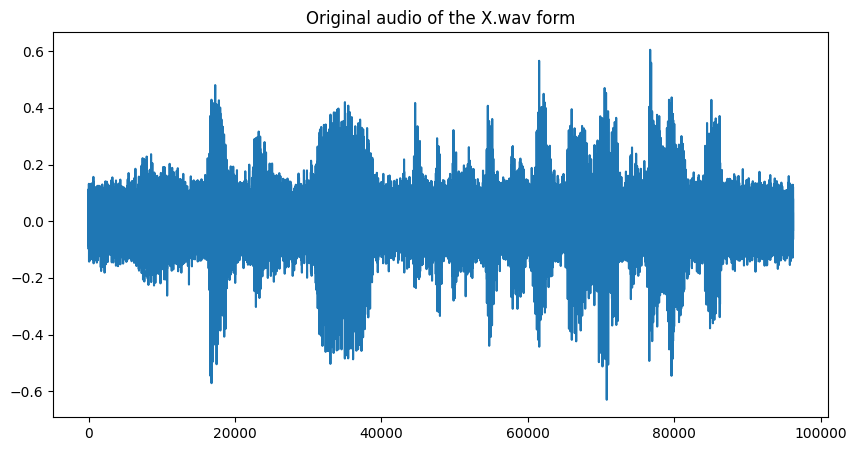

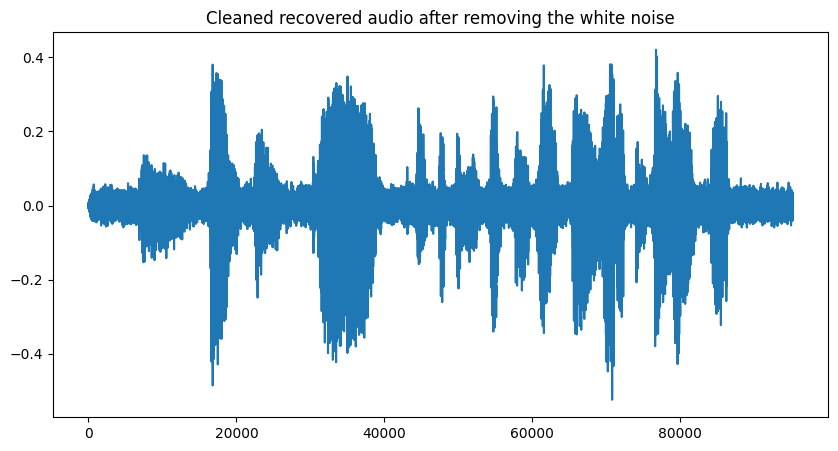

In [ ]:
#Ploting original signal
x_range = range(signal.shape[0])
plt.figure(figsize= (10,5))
plt.title("Original audio of the X.wav form")
plt.plot(x_range, signal)
plt.show()

#Ploting recovered signal
x_range = range(signal_recovered.shape[0])
plt.figure(figsize= (10,5))
plt.title("Cleaned recovered audio after removing the white noise")
plt.plot(x_range, signal_recovered)
plt.show()

From the figures above we can infer that plot for the original wave form is not too spiky due to some noise or a kind of beep sound. But in the cleaned audio plot we can see that the it spiky due to noise removal from the audio and its quite clear when compared with the original wave form

# **P2: DCT and PCA**

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [3]:
a = "/content/drive/MyDrive/Colab drive/s.wav"

signal1, sampling_rate = librosa.load(a, sr=None)
print("Total number of samples in s.wav:", signal1.shape)

Total number of samples in s.wav: (5000000,)


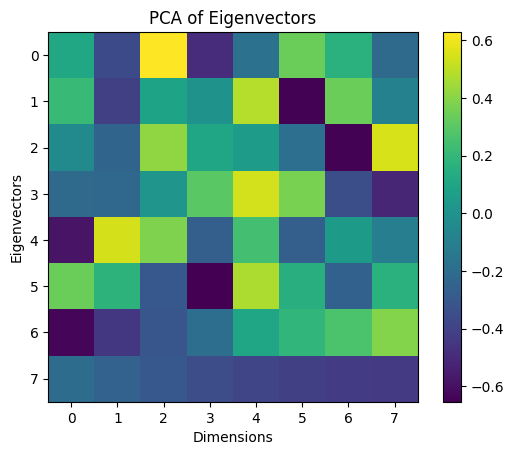

In [9]:
audio_data = signal1

def prepare_data(audio_data, num_samples, num_iterations):
    X = np.zeros((num_samples, num_iterations))

    for i in range(num_iterations):
        start_index = np.random.randint(0, len(audio_data) - num_samples)
        X[:, i] = audio_data[start_index:start_index+num_samples]

    return X

X_10 = prepare_data(audio_data, 8, 10)


def eigen_decomp(X):
    X_mean = X - np.mean(X, axis=1).reshape(-1, 1)
    X_covariance = np.dot(X_mean, X_mean.T) / (X.shape[1] - 1)
    eigenvalues, eigenvectors = np.linalg.eigh(X_covariance)

    # sorted_indices = np.argsort(eigenvalues)[::-1]
    # eigenvectors_sorted = eigenvectors[:, sorted_indices]
    eigenvectors_sorted = eigenvectors

    plt.imshow(eigenvectors_sorted.T, cmap='viridis')
    plt.title("PCA of Eigenvectors")
    plt.xlabel("Dimensions")
    plt.ylabel("Eigenvectors")
    plt.colorbar()
    plt.show()

eigen_decomp(X_10)


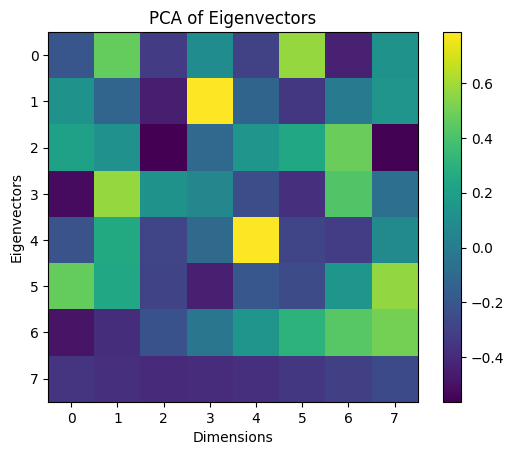

In [7]:
X_100 = prepare_data(audio_data, 8, 100)
eigen_decomp(X_100)

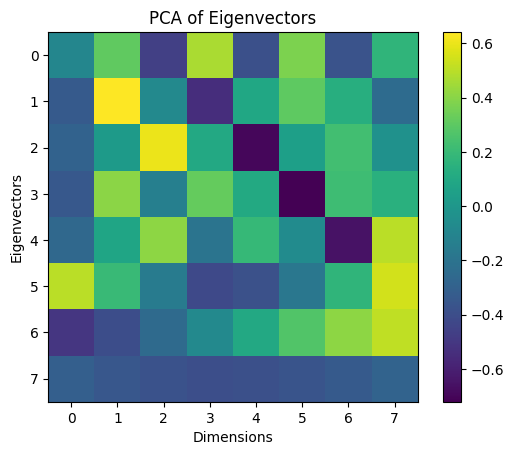

In [8]:
X_1000 = prepare_data(audio_data, 8, 1000)
eigen_decomp(X_1000)

After performing the PCA with 10,100 and 1000 sample, we can infer that PCA is getting better in as we increase the sample size.

Some pros of using PCA is:
*   PCA reduces the dimensionality of the data by transforming it into a new coordinate system where the axes are the principal components. This can be useful for visualization, feature extraction, and data compression.
*   PCA aims to find the directions in which the data varies the most, making it effective for capturing the main patterns in the data.

Some cons of using PCA is:


*   PCA is sensitive to the scale of the data, so it's important to standardize or normalize the features before applying PCA.
*   PCA performs a linear transformation of the data, which means it may not capture complex nonlinear relationships in the data.



# **P3: Parallax**

In [10]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
j_data = loadmat('/content/drive/MyDrive/Colab drive/june.mat')
d_data = loadmat('/content/drive/MyDrive/Colab drive/december.mat')

jstars = j_data['june']
dstars = d_data['december']

print("The shape of the June data matrix: ",jstars.shape)
print("The shape of the December data matrix: ",dstars.shape)

The shape of the June data matrix:  (2700, 2)
The shape of the December data matrix:  (2700, 2)


Load both the matrix using scipy and print the shapes of the matrix june and december

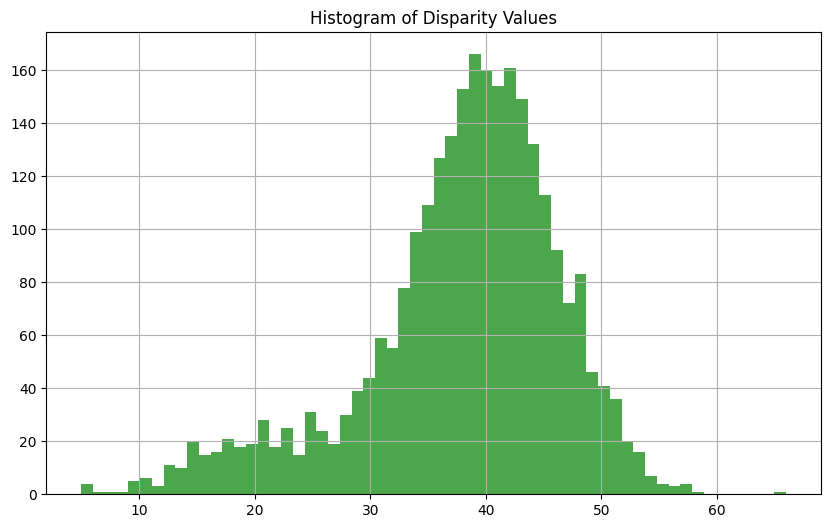

In [12]:
jx = jstars[:, 0]
dx = dstars[:, 0]

disparity = dx - jx

plt.figure(figsize=(10, 6))
plt.hist(disparity, bins=60, color='green', alpha=0.7)
plt.title('Histogram of Disparity Values')
plt.grid(True)
plt.show()


Extract the x-coordinates of stars from june and december data and calculate the disparity. The above histogram plot represents the disparity values between the the two matrixes.

From the above histogram, we can notice there are two clusters with varying means in the shape of two overlapping gaussian distributions.

In [15]:
def initialize_centroids(data, k):

    centroids_idx = np.random.choice(data.shape[0], k, replace=False)
    centroids = data[centroids_idx]
    return centroids

def assign_clusters(data, centroids):

    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    clusters = np.argmin(distances, axis=1)
    return clusters

def update_centroids(data, clusters, k):
    centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        centroids[i] = np.mean(data[clusters == i], axis=0)
    return centroids

def kmeans(data, k, max_iters=100):

    centroids = initialize_centroids(data, k)
    for _ in range(max_iters):

        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids
    return clusters, centroids

k = 2
disparity = disparity.reshape(-1, 1)
clusters, centroids = kmeans(disparity, k)

for i, centroid in enumerate(centroids):
    cluster_mean = np.mean(disparity[clusters == i])
    print(f"Cluster {i + 1} mean:", cluster_mean)


Cluster 1 mean: 42.31183368869936
Cluster 2 mean: 27.74271844660194


The above code is the implementation of the K-means algorithm. First, randomly select k data points as initial centroids and compute the distance between each data point and centroids. Then assign each data point to its nearest centroid. Compute the mean of data points assigned to the ith cluster.


The means of the 1st cluster and 2nd cluster using K-means are 42.311 and 27.742 respectively.

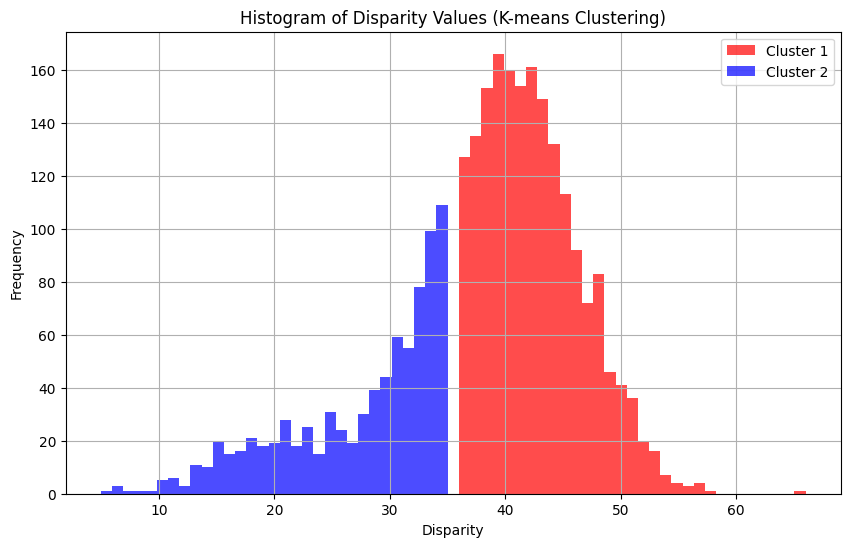

In [19]:
plt.figure(figsize=(10, 6))

plt.hist(disparity[clusters == 0], bins=31, color='red', alpha=0.7, label='Cluster 1')
plt.hist(disparity[clusters == 1], bins=31, color='blue', alpha=0.7, label='Cluster 2')

plt.title('Histogram of Disparity Values (K-means Clustering)')
plt.xlabel('Disparity')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

The cluster centroids are positioned at 42.312 and 27.743.

Given the substantial movement of stars within our galaxy compared to those in our neighboring galaxy, we interpret the cluster mean of 42.312 as indicative of our galaxy, while the mean of 27.743 represents our neighboring galaxy.

# **P4: GMM for Parallax**

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

The above algorithm is the Expected Maximization. The gaussian density function calculates the exponential term and the density. Then the expected maximization function initializes all the probabilities of stars in clusters using initial centroid estimates

In [128]:
def normaldist_pd(mu, sigma, x):
    pdf = (1/np.sqrt((2*np.pi*(sigma**2)))) * (np.exp(-(((x-mu)**2)/(2*(sigma**2)))))
    return pdf

def expected_maximization(data, tolerance):

    # By observing visually from the historgram we can estimate the probabilities of the clusters
    pA, pB = 0.1, 0.9

    # Means for both the clusters are initialized radnomly using random.uniform function
    mA, mB = random.uniform(min(disparity), max(disparity)), random.uniform(min(disparity), max(disparity))
    sA, sB = np.sqrt(np.sum((disparity - mA)**2) / len(disparity)), np.sqrt(np.sum((disparity - mB)**2) / len(disparity))

    ic = 0
    while ic <= max(disparity):
        pgA = normaldist_pd(mA, sA, data)
        pgB = normaldist_pd(mB, sB, data)
        pgA[pgA == 0] = 0.05
        pgB[pgB == 0] = 0.05

        #E-step
        lhA, lhB = (pA * pgA)/((pA * pgA) + (pB * pgB)), (pB * pgB)/((pA * pgA) + (pB * pgB))
        pre_mA, pre_mB = mA, mB

        #M-step
        mA, mB = np.sum(lhA * data)/np.sum(lhA), np.sum(lhB * data)/np.sum(lhB)
        sA = np.sqrt(np.sum(lhA * (data - mA) * (data - mA))/np.sum(lhA))
        sB = np.sqrt(np.sum(lhB * (data - mB) * (data - mB))/np.sum(lhB))

        ic += 1
        if np.abs(mA - pre_mA) < tolerance and np.abs(mB - pre_mB) < tolerance:
            break

    cmat = np.argmax(np.concatenate((lhA, lhB), axis=1), axis=1)
    view_em = pd.DataFrame(disparity, columns=['Disparity Data'])
    view_em['Cluster'] = cmat
    return mA, mB, view_em

In [134]:
mA, mB, view_em = expected_maximization(disparity, 0.0001)
print(f'The cluster means found using GMM are: {np.round(mA, 3)} and {np.round(mB, 3)}')

The cluster means found using GMM are: 19.985 and 40.003


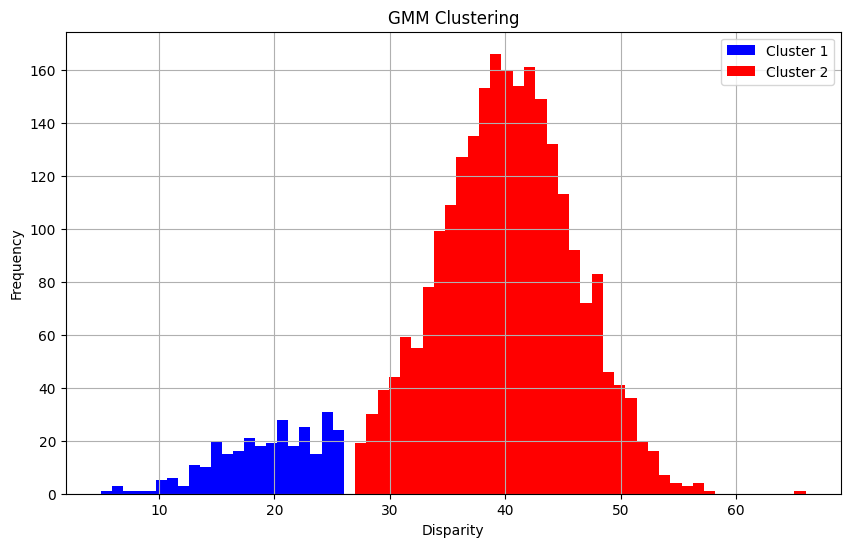

In [130]:
plt.figure(figsize=(10, 6))

plt.hist(view_em['Disparity Data'][view_em['Cluster'] == 0], bins=22, color='blue', label='Cluster 1')
plt.hist(view_em['Disparity Data'][view_em['Cluster'] == 1], bins=40, color='red', label='Cluster 2')

plt.title('GMM Clustering')
plt.xlabel('Disparity')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

Based on the plot above, we can notice that GMM outperforms k-means in segregating stars from our galaxy and those from the neighboring galaxy. This distinction is evident as k-means tends to form circular clusters around the mean, whereas GMM clusters exhibit an elliptical shape. While k-means relies on a distance metric leading to sharp decision boundaries, GMM employs the probability of a data point belonging to a cluster, resulting in softer decision boundaries.

In [136]:
%%shell
jupyter nbconvert --to html /content/MLSP_H2.ipynb

[NbConvertApp] Converting notebook /content/MLSP_H2.ipynb to html
[NbConvertApp] Writing 1717534 bytes to /content/MLSP_H2.html
